Let's use this notebook to make a lot of subplots for my thesis!

In [1]:
# let's import things
import h5py as h5 
import pandas as pd
from astropy.table import Table
from astropy import units as u
from astropy import constants as const
import numpy as np
import matplotlib.pyplot as plt
plt.rc('text.latex', preamble=r'\usepackage{textgreek}')
plt.rc('font', family='serif')
import sys
import os
from scipy import stats
import seaborn as sns
import matplotlib as mpl

# Add the subdir to sys.path
sys.path.append('/home/jovyan/home/research_work/useful_py_scripts/')

# Now you can import the module
import useful_fncs 

# import for axes labels 
plt.rcParams.update({
    "text.usetex": False,
    "font.family": "sans-serif"
})

We need to make a function which when I give it an HDF5 file will give me the information needed to plot the redshift with rates and the merger rate at redshift zero

In [2]:
# let's make a function where we can get the triangle plot info

def triangle_results(pathToweights_H5):

    # we first need to gather the information for the file of interest
    # reading in the HDF5 file
    Data_weights = h5.File(pathToweights_H5,"r")

    # let's gather the system parameters group 
    SP_WD_data = pd.DataFrame() # making a pandas dataframe

    for key in Data_weights["BSE_Double_Compact_Objects"].keys(): #looping through the "keys" or paramters in BSE_System_Parameters

        SP_WD_data[key] = Data_weights["BSE_Double_Compact_Objects"][key][()] # adding these columns to the dataframe

    # Rates info directly taking out the 
    #merger_SEED = Data_weights['Rates_mu00.025_muz-0.049_alpha-1.79_sigma01.129_sigmaz0.048']['SEED'][()]
    rates_DCO = Data_weights['Rates_mu00.025_muz-0.049_alpha-1.79_sigma01.129_sigmaz0.048']['merger_rate'][()]
    rates_z0_DCO = Data_weights['Rates_mu00.025_muz-0.049_alpha-1.79_sigma01.129_sigmaz0.048']['merger_rate_z0'][()]
    DCO_mask = Data_weights['Rates_mu00.025_muz-0.049_alpha-1.79_sigma01.129_sigmaz0.048']['DCOmask'][()]
    redshifts = Data_weights['Rates_mu00.025_muz-0.049_alpha-1.79_sigma01.129_sigmaz0.048']['redshifts'][()]
    # rates_info = Data_weights["Rates_mu00.025_muz-0.049_alpha-1.79_sigma01.129_sigmaz0.048"]

    Data_weights.close()

    ### Let's first get the info needed to get the triangle


    #let's next make sure that we are selecting for WD+WD systems
    SP_DCO_DATA = SP_WD_data[DCO_mask]

    # let's make sure that at least one of these white dwarfs are COWD
    HeWD_bool,COWD_bool,ONeWD_bool,HeCOWD_bool,HeONeWD_bool,COHeWD_bool,COONeWD_bool,ONeHeWD_bool,ONeCOWD_bool = useful_fncs.WD_BINARY_BOOLS(SP_DCO_DATA)
    carbon_oxygen_bool = np.logical_or(ONeCOWD_bool,np.logical_or(COONeWD_bool,np.logical_or(COHeWD_bool,np.logical_or(COWD_bool,HeCOWD_bool))))
    SP_COWD_DATA = SP_DCO_DATA[carbon_oxygen_bool]

    WDWD_merger_rate_Z0 = rates_z0_DCO[carbon_oxygen_bool]
    
    # gathering the masses
    Mass1 = np.array(SP_COWD_DATA['Mass(1)'])
    Mass2 = np.array(SP_COWD_DATA['Mass(2)'])
    # making M1 be the larger mass
    M1 = np.maximum(Mass1,Mass2)
    M2 = np.minimum(Mass1, Mass2)

    return([M1,M2,WDWD_merger_rate_Z0])

In [3]:
# let's make a function that gives us the rate information

def redshift_rates_results(pathToweights_H5):
    # we first need to gather the information for the file of interest
    # reading in the HDF5 file
    Data_weights = h5.File(pathToweights_H5,"r")

    # let's gather the system parameters group 
    SP_WD_data = pd.DataFrame() # making a pandas dataframe

    for key in Data_weights["BSE_Double_Compact_Objects"].keys(): #looping through the "keys" or paramters in BSE_System_Parameters

        SP_WD_data[key] = Data_weights["BSE_Double_Compact_Objects"][key][()] # adding these columns to the dataframe

    # Rates info directly taking out the 
    #merger_SEED = Data_weights['Rates_mu00.025_muz-0.049_alpha-1.79_sigma01.129_sigmaz0.048']['SEED'][()]
    rates_DCO = Data_weights['Rates_mu00.025_muz-0.049_alpha-1.79_sigma01.129_sigmaz0.048']['merger_rate'][()]
    rates_z0_DCO = Data_weights['Rates_mu00.025_muz-0.049_alpha-1.79_sigma01.129_sigmaz0.048']['merger_rate_z0'][()]
    DCO_mask = Data_weights['Rates_mu00.025_muz-0.049_alpha-1.79_sigma01.129_sigmaz0.048']['DCOmask'][()]
    redshifts = Data_weights['Rates_mu00.025_muz-0.049_alpha-1.79_sigma01.129_sigmaz0.048']['redshifts'][()]
    # rates_info = Data_weights["Rates_mu00.025_muz-0.049_alpha-1.79_sigma01.129_sigmaz0.048"]

    Data_weights.close()

    # let's now gather the info for the plots
    # making the DCO table
    DCO_data_masked = SP_WD_data[DCO_mask]
    # getting the COWD systems
    HeWD_bool,COWD_bool,ONeWD_bool,HeCOWD_bool,HeONeWD_bool,COHeWD_bool,COONeWD_bool,ONeHeWD_bool,ONeCOWD_bool = useful_fncs.WD_BINARY_BOOLS(DCO_data_masked)
    carbon_oxygen_bool = np.logical_or(ONeCOWD_bool,np.logical_or(COONeWD_bool,np.logical_or(COHeWD_bool,np.logical_or(COWD_bool,HeCOWD_bool))))
    DCO_COWD_data = DCO_data_masked[carbon_oxygen_bool]

    # selecting the relevant bools
    mtot_mchan_bool = DCO_data_masked['Mass(1)']+DCO_data_masked['Mass(2)']>1.4 #where the combined mass exceeds the Chandrasekhar mass
    chan_bool = mtot_mchan_bool*carbon_oxygen_bool

    # let's gather the NSNS merger information
    NSNS_bool = np.logical_and(DCO_data_masked['Stellar_Type(1)']==13,DCO_data_masked['Stellar_Type(2)']==13)

    # the redshift bools to plot the rates with
    rates_reshift_array = rates_DCO[carbon_oxygen_bool] # am i using the same rates
    rates_redshift_chan = rates_DCO[chan_bool] 

    # computing the rates
    # # the merger rate for COWD of at least 0.9 solar masses
    nsns_rate = np.sum(rates_DCO[NSNS_bool],axis=0)

    # the merger rate for all systems with at least a COWD
    cowd_rate = np.sum(rates_DCO[carbon_oxygen_bool],axis=0)

    # the merger rate for systems with a total mass that exceed the Chandrasekhar mass
    chan_rate = np.sum(rates_DCO[chan_bool],axis=0)

    # let's add the flags for specific calssifications of SN Ia
    SN_Ia_HVS,two_star_SNIA,Champagne_Supernova = useful_fncs.check_if_SNIA(DCO_COWD_data['Mass(1)'],DCO_COWD_data['Mass(2)'])
    # adding the flags to the dataframe
    DCO_COWD_data = DCO_COWD_data.assign(SN_Ia_HVS = SN_Ia_HVS)
    DCO_COWD_data = DCO_COWD_data.assign(two_star_SNIA = two_star_SNIA)
    DCO_COWD_data = DCO_COWD_data.assign(Champagne_Supernova = Champagne_Supernova)
    any_SNIA = np.logical_or(DCO_COWD_data['Champagne_Supernova']== True,
                            np.logical_or(DCO_COWD_data['SN_Ia_HVS']==True,DCO_COWD_data['two_star_SNIA']==True))

    # the rates for shen 2025 sne ia
    sn_ia_hvs_rates = np.sum(rates_reshift_array[SN_Ia_HVS,:],axis=0)
    two_star_snia_rates = np.sum(rates_reshift_array[two_star_SNIA,:],axis=0)
    champagne_snia_rates = np.sum(rates_reshift_array[Champagne_Supernova,:],axis=0)
    any_snia_rate = np.sum(rates_reshift_array[any_SNIA,:],axis=0)


    return([cowd_rate,chan_rate,any_snia_rate,sn_ia_hvs_rates,two_star_snia_rates,champagne_snia_rates,nsns_rate,redshifts,rates_reshift_array,rates_redshift_chan])

Now let's call these functions

In [4]:
# for the triangle plot
triangle_plot_info_CE025 = triangle_results('/home/jovyan/home/copy_h5_files/v03.08.01/CEalpha025/N1e6_MassiveWDWD_NSNS_CEalpha025_fbinNone.h5')
triangle_plot_info_CE05 = triangle_results('/home/jovyan/home/copy_h5_files/v03.08.01/CEalpha05/N1e6_MassiveWDWD_NSNS_CEalpha05_fbinNone.h5')
triangle_plot_info_CE075 = triangle_results('/home/jovyan/home/copy_h5_files/v03.08.01/CEalpha075/N1e6_MassiveWDWD_NSNS_CEalpha075_fbinNone.h5')
triangle_plot_info_CE2 = triangle_results('/home/jovyan/home/copy_h5_files/v03.08.01/CEalpha2/N1e6_MassiveWDWD_NSNS_CEalpha2_fbinNone/N1e6_MassiveWDWD_NSNS_CEalpha2_fbinNone.h5')

In [6]:
# for the redshift with rates plot
redshift_rates_plot_info_CE025 = redshift_rates_results('/home/jovyan/home/copy_h5_files/v03.08.01/CEalpha025/N1e6_MassiveWDWD_NSNS_CEalpha025_fbinNone.h5')
redshift_rates_plot_info_CE05 = redshift_rates_results('/home/jovyan/home/copy_h5_files/v03.08.01/CEalpha05/N1e6_MassiveWDWD_NSNS_CEalpha05_fbinNone.h5')
redshift_rates_plot_info_CE075 = redshift_rates_results('/home/jovyan/home/copy_h5_files/v03.08.01/CEalpha075/N1e6_MassiveWDWD_NSNS_CEalpha075_fbinNone.h5')
redshift_rates_plot_info_CE2 = redshift_rates_results('/home/jovyan/home/copy_h5_files/v03.08.01/CEalpha2/N1e6_MassiveWDWD_NSNS_CEalpha2_fbinNone/N1e6_MassiveWDWD_NSNS_CEalpha2_fbinNone.h5')

Let's now try to make subplots

In [8]:
triangle_data_list = [triangle_plot_info_CE025,triangle_plot_info_CE05,triangle_plot_info_CE075,triangle_plot_info_CE2]
redshift_rates_data_list = [redshift_rates_plot_info_CE025,redshift_rates_plot_info_CE05,redshift_rates_plot_info_CE075,redshift_rates_plot_info_CE2]

In [9]:
# defining the observed rates
# extracting the redshifts and rates from Briel et al
# units in the appendix should be in h^-3 y^-1 Gpc^-3 so we must convert below to get yr^-1 Gpc^-3
h_little = 0.6766

redshifts_briel = [
    0, 0.01, 0.03, (0.025+0.050)/2, 0.073, (0.05+0.15)/2, (0.075+0.125)/2, 0.11, 0.11, 0.13, 
    0.15, (0.125+0.175)/2, 0.16, (0.175+0.225)/2, 0.2, 0.25, (0.15+0.35)/2, (0.225+0.275)/2, 
    0.26, 0.3, (0.275+0.325)/2, 0.35, 0.35, 0.42, 0.44, 0.45, 0.45, (0.35+0.55)/2, 0.46, 0.47, 
    0.47, 0.55, 0.55, 0.55, 0.62, 0.65, (0.55+0.75)/2, 0.65, 0.74, 0.75, 0.75, 0.75, 0.8, 0.83, 0.85, 
    0.85, 0.94, 0.95, 0.95, 1.05, 1.1, 1.14, 1.21, 1.23, 1.25, 1.59, 1.61, 1.69, 1.75, 2.25
]

rates_briel = [
    0.77, 0.82, 0.82, 0.81, 0.71, 1.60, 0.76, 1.08, 0.72, 0.58, 0.93, 0.90, 0.41, 1.01, 0.58,
    1.05, 1.14, 1.06, 0.82, 0.99, 1.27, 0.99, 1.05, 1.34, 0.76, 0.90, 1.05, 1.52, 1.40, 1.22, 
    2.33, 0.93, 1.40, 1.52, 3.76, 1.40, 2.01, 1.43, 2.30, 1.49, 1.98, 1.69, 2.45, 3.79, 2.27, 
    1.66, 1.31, 2.22, 2.24, 2.30, 2.16, 2.06, 3.85, 2.45, 1.87, 1.31, 1.22, 2.97, 2.10, 1.43
]

# converting the rates to the correct units
rates_briel = np.array(rates_briel)
converted_rates_briel = (rates_briel*(10**5))*(h_little**3)

## uncertainties
lower_limits = [
    -0.10, -0.26, -0.32, -0.24, -0.08, -0.85, -0.13, -0.29, -0.20, -0.18, -0.67, -0.10, -0.26, -0.09, 
    -0.23, -0.76, -0.35, -0.08, -0.20, -0.44, -0.10, -0.55, -0.17, -0.93, -0.39, -0.44, -0.17, -0.38, 
    -0.50, -0.17, -0.79, -0.41, -0.17, -0.26, -1.66, -0.15, -0.52, -0.50, -1.20, -0.55, -0.61, -0.17, 
    -0.54, -0.79, -0.64, -0.15, -0.55, -0.73, -0.23, -0.82, -0.35, -0.53, -0.85, -0.82, -0.64, -0.64, 
    -0.67, -1.08, -0.87, -1.11
]

lower_limits = np.array(lower_limits)
converted_lower_limits = (lower_limits*(10**5)*(h_little**3))

upper_limits = [
    0.10, 0.26, 0.32, 0.33, 0.08, 1.46, 0.15, 0.29, 0.08, 0.20, 0.67, 0.11, 0.26, 0.09, 0.23,
    1.75, 0.38, 0.09, 0.20, 0.47, 0.11, 0.55, 0.17, 1.22, 0.67, 0.44, 0.17, 0.32, 0.50, 0.17, 
    1.08, 0.41, 0.17, 0.29, 2.57, 0.15, 0.55, 0.50, 0.96, 0.79, 0.61, 0.17, 0.67, 0.96, 0.64, 
    0.15, 0.64, 0.73, 0.23, 0.82, 0.35, 0.70, 1.05, 0.73, 0.90, 0.99, 1.14, 1.57, 1.31, 2.77
]

upper_limits = np.array(upper_limits)
converted_upper_limits = (upper_limits*(10**5)*(h_little**3))

# multiplied the lower errors by -1 so make them positive to avoid the plt.errorbar error 
y_error = [-1*(converted_lower_limits), converted_upper_limits]
# y_error = [converted_rates_briel+ converted_lower_limits, converted_rates_briel + converted_upper_limits]
# converted_y_error = y_error*(10**5)*(0.6766)

# error_bars = y_error


/tmp/ipykernel_27706/747435123.py:272: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


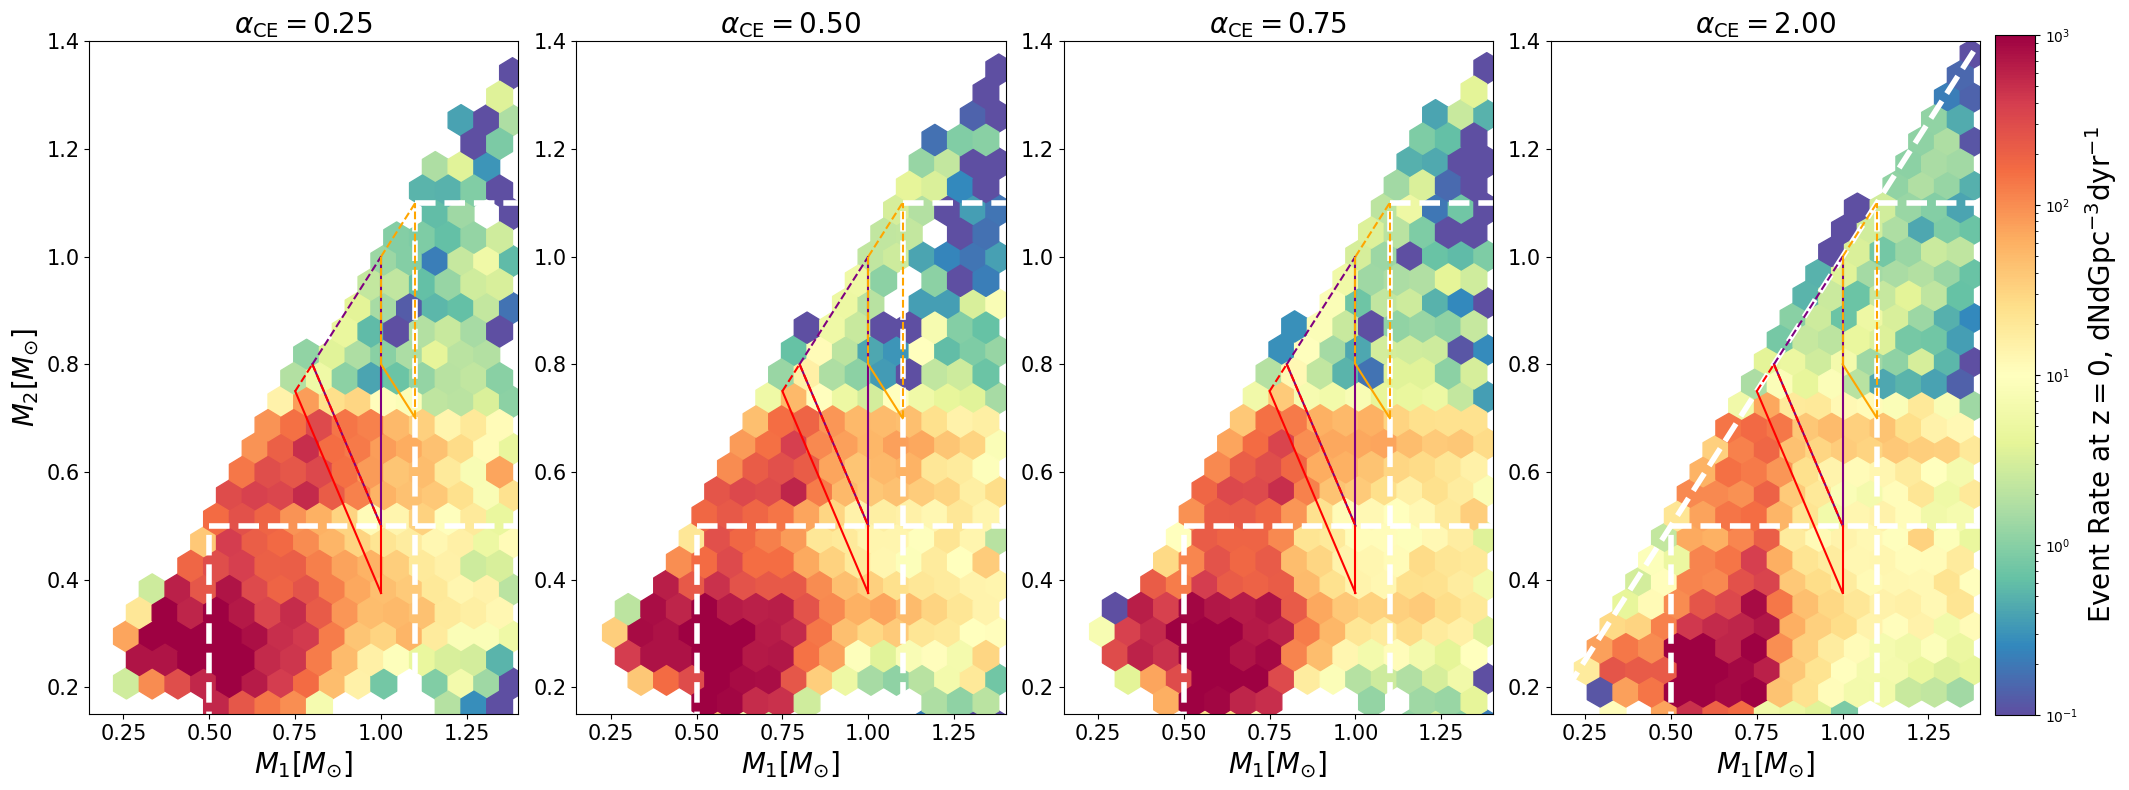

In [ ]:
fig, ((ax1, ax2, ax3, ax4)) = plt.subplots(1, 4, figsize=(20,8))

####### Triangle plots
vmin = 10**-1
vmax = 10**3

# for 2D histogram or 2D plots, we need to use somethign that will allow us to use a color bar so something liek pcolormesh or plt.contour or hexbin
hb = ax1.hexbin(triangle_data_list[0][0],triangle_data_list[0][1],C=triangle_data_list[0][2], gridsize=(15,15), reduce_C_function = np.sum, 
                cmap=sns.color_palette("Spectral_r",as_cmap=True),norm='log',vmin=vmin,vmax=vmax) # C is value of weights, 1e3- 10**3
                # use symlog when you also want to cover negative values    
# right now we are not dividing by the bin size, so when we chage the bins - it changes the shape of our dist 
zvalue_array = hb.get_array() # the merger rates of the histigram 

# colorbar
# cb = fig.colorbar(hb,ax=ax1)
# cb.set_label(label="Merger Rate at $\mathrm{z =0}$, $\mathrm{dNdGpc^{-3}dyr^{-1}}$", fontsize = 15)

max_mass_lim = 1.4
ax1.set_ylim(0.15,max_mass_lim)
ax1.set_xlim(0.15,max_mass_lim)

# let's add the mass restrictions for each case of binary WDs as prompted by Shen 2025

xlim = max(triangle_data_list[0][0])
ylim = max(triangle_data_list[0][0])

linecolors = 'white'
linewidths = 4

ax1.axline((0,0), (max(triangle_data_list[0][0]),max(triangle_data_list[0][0])), color=linecolors, ls='--', lw=linewidths, transform=plt.gca().transAxes)

#Helium WD cutoff
ax1.vlines(x=[0.5], ymin=0, ymax=0.5, colors=linecolors, ls='--', lw=linewidths) # vertical line
ax1.plot([0.5,max_mass_lim],[0.5,0.5],color=linecolors,lw=linewidths, ls='--') # horizontal line

#Carbon oxygen WD cutoff
ax1.vlines(x=[1.1], ymin=0, ymax=1.1, colors=linecolors, ls='--', lw=linewidths) # vertical line
ax1.plot([1.1,max_mass_lim],[1.1,1.1],color=linecolors,lw=linewidths, ls='--') # horizontal line

# purple region - 2 star SN Ia
ax1.plot([0.8,1],[0.8,0.5],color='purple') # bottom boundary
ax1.plot([1.0,1.0],[1.0,0.5],color='purple') # side boundary
ax1.plot([0.8,1.0],[0.8,1.0],color='purple',ls='--') # top boundary 


# red region - hypervelocity WDs
ax1.plot([0.8,1],[0.8,0.5],color='red',ls='--') # overlapping boundary
ax1.plot([0.75,1.0],[0.75,0.375],color='red') # bottom boundary
ax1.plot([1.0,1.0],[0.5,0.375],color='red') # side boundary
ax1.plot([0.75,0.8],[0.75,0.8],color='red',ls='--') # top boundary
ax1.plot([1.1,1.1],[0.7,1.1],color='orange',ls='--') # left side boundary 

# orange region - 2003fg HVS
ax1.plot([1.0,1.1],[0.8,0.7],color='orange') # botton boundary
ax1.plot([1.0,1.0],[1.0,0.8],color='orange',ls='--') # left side overlapping boundary
ax1.plot([1.0,1.1],[1.0,1.1],color='orange',ls='--') # top boundary


ax1.tick_params(labelsize=15)
# ax1.set_yticklabels(fontsize=15)
ax1.set_xlabel("$M_{1}$[$M_{\odot}$]",fontsize=20)
ax1.set_ylabel("$M_{2}$[$M_{\odot}$]",fontsize=20)
ax1.set_title(r"$\alpha_{\mathrm{CE}}=0.25$",fontsize=20)





###### CE 05
# for 2D histogram or 2D plots, we need to use somethign that will allow us to use a color bar so something liek pcolormesh or plt.contour or hexbin
hb = ax2.hexbin(triangle_data_list[1][0],triangle_data_list[1][1],C=triangle_data_list[1][2], gridsize=(15,15), reduce_C_function = np.sum, 
                cmap=sns.color_palette("Spectral_r",as_cmap=True),norm='log',vmin=vmin,vmax=vmax) # C is value of weights, 1e3- 10**3
                # use symlog when you also want to cover negative values    
# right now we are not dividing by the bin size, so when we chage the bins - it changes the shape of our dist 
zvalue_array = hb.get_array() # the merger rates of the histigram 

# colorbar
# cb = fig.colorbar(hb,ax=ax2)
# cb.set_label(label="Merger Rate at $\mathrm{z =0}$, $\mathrm{dNdGpc^{-3}dyr^{-1}}$", fontsize = 15)

max_mass_lim = 1.4
ax2.set_ylim(0.15,max_mass_lim)
ax2.set_xlim(0.15,max_mass_lim)

# let's add the mass restrictions for each case of binary WDs as prompted by Shen 2025

xlim = max(triangle_data_list[1][0])
ylim = max(triangle_data_list[1][0])

linecolors = 'white'
linewidths = 4

ax2.axline((0,0), (max(triangle_data_list[1][0]),max(triangle_data_list[1][0])), color=linecolors, ls='--', lw=linewidths, transform=plt.gca().transAxes)

#Helium WD cutoff
ax2.vlines(x=[0.5], ymin=0, ymax=0.5, colors=linecolors, ls='--', lw=linewidths) # vertical line
ax2.plot([0.5,max_mass_lim],[0.5,0.5],color=linecolors,lw=linewidths, ls='--') # horizontal line

#Carbon oxygen WD cutoff
ax2.vlines(x=[1.1], ymin=0, ymax=1.1, colors=linecolors, ls='--', lw=linewidths) # vertical line
ax2.plot([1.1,max_mass_lim],[1.1,1.1],color=linecolors,lw=linewidths, ls='--') # horizontal line

# purple region - 2 star SN Ia
ax2.plot([0.8,1],[0.8,0.5],color='purple') # bottom boundary
ax2.plot([1.0,1.0],[1.0,0.5],color='purple') # side boundary
ax2.plot([0.8,1.0],[0.8,1.0],color='purple',ls='--') # top boundary 


# red region - hypervelocity WDs
ax2.plot([0.8,1],[0.8,0.5],color='red',ls='--') # overlapping boundary
ax2.plot([0.75,1.0],[0.75,0.375],color='red') # bottom boundary
ax2.plot([1.0,1.0],[0.5,0.375],color='red') # side boundary
ax2.plot([0.75,0.8],[0.75,0.8],color='red',ls='--') # top boundary
ax2.plot([1.1,1.1],[0.7,1.1],color='orange',ls='--') # left side boundary 

# orange region - 2003fg HVS
ax2.plot([1.0,1.1],[0.8,0.7],color='orange') # botton boundary
ax2.plot([1.0,1.0],[1.0,0.8],color='orange',ls='--') # left side overlapping boundary
ax2.plot([1.0,1.1],[1.0,1.1],color='orange',ls='--') # top boundary


ax2.tick_params(labelsize=15)
# ax2.set_yticklabels(fontsize=15)
ax2.set_xlabel("$M_{1}$[$M_{\odot}$]",fontsize=20)
# ax2.set_ylabel("$M_{2}$[$M_{\odot}$]",fontsize=20)
ax2.set_title(r"$\alpha_{\mathrm{CE}}=0.50$",fontsize=20)








###### CE 075
# for 2D histogram or 2D plots, we need to use somethign that will allow us to use a color bar so something liek pcolormesh or plt.contour or hexbin
hb = ax3.hexbin(triangle_data_list[2][0],triangle_data_list[2][1],C=triangle_data_list[2][2], gridsize=(15,15), reduce_C_function = np.sum, 
                cmap=sns.color_palette("Spectral_r",as_cmap=True),norm='log',vmin=vmin,vmax=vmax) # C is value of weights, 1e3- 10**3
                # use symlog when you also want to cover negative values    
# right now we are not dividing by the bin size, so when we chage the bins - it changes the shape of our dist 
zvalue_array = hb.get_array() # the merger rates of the histigram 

# colorbar
# cb = fig.colorbar(hb,ax=ax3)
# cb.set_label(label="Merger Rate at $\mathrm{z =0}$, $\mathrm{dNdGpc^{-3}dyr^{-1}}$", fontsize = 15)

max_mass_lim = 1.4
ax3.set_ylim(0.15,max_mass_lim)
ax3.set_xlim(0.15,max_mass_lim)

# let's add the mass restrictions for each case of binary WDs as prompted by Shen 2025

xlim = max(triangle_data_list[2][0])
ylim = max(triangle_data_list[2][0])

linecolors = 'white'
linewidths = 4

ax3.axline((0,0), (max(triangle_data_list[2][0]),max(triangle_data_list[2][0])), color=linecolors, ls='--', lw=linewidths, transform=plt.gca().transAxes)

#Helium WD cutoff
ax3.vlines(x=[0.5], ymin=0, ymax=0.5, colors=linecolors, ls='--', lw=linewidths) # vertical line
ax3.plot([0.5,max_mass_lim],[0.5,0.5],color=linecolors,lw=linewidths, ls='--') # horizontal line

#Carbon oxygen WD cutoff
ax3.vlines(x=[1.1], ymin=0, ymax=1.1, colors=linecolors, ls='--', lw=linewidths) # vertical line
ax3.plot([1.1,max_mass_lim],[1.1,1.1],color=linecolors,lw=linewidths, ls='--') # horizontal line

# purple region - 2 star SN Ia
ax3.plot([0.8,1],[0.8,0.5],color='purple') # bottom boundary
ax3.plot([1.0,1.0],[1.0,0.5],color='purple') # side boundary
ax3.plot([0.8,1.0],[0.8,1.0],color='purple',ls='--') # top boundary 


# red region - hypervelocity WDs
ax3.plot([0.8,1],[0.8,0.5],color='red',ls='--') # overlapping boundary
ax3.plot([0.75,1.0],[0.75,0.375],color='red') # bottom boundary
ax3.plot([1.0,1.0],[0.5,0.375],color='red') # side boundary
ax3.plot([0.75,0.8],[0.75,0.8],color='red',ls='--') # top boundary
ax3.plot([1.1,1.1],[0.7,1.1],color='orange',ls='--') # left side boundary 

# orange region - 2003fg HVS
ax3.plot([1.0,1.1],[0.8,0.7],color='orange') # botton boundary
ax3.plot([1.0,1.0],[1.0,0.8],color='orange',ls='--') # left side overlapping boundary
ax3.plot([1.0,1.1],[1.0,1.1],color='orange',ls='--') # top boundary


ax3.tick_params(labelsize=15)
# ax3.set_yticklabels(fontsize=15)
ax3.set_xlabel("$M_{1}$[$M_{\odot}$]",fontsize=20)
# ax3.set_ylabel("$M_{2}$[$M_{\odot}$]",fontsize=20)
ax3.set_title(r"$\alpha_{\mathrm{CE}}=0.75$",fontsize=20)







###### CE 2
# for 2D histogram or 2D plots, we need to use somethign that will allow us to use a color bar so something liek pcolormesh or plt.contour or hexbin
hb = ax4.hexbin(triangle_data_list[3][0],triangle_data_list[3][1],C=triangle_data_list[3][2], gridsize=(15,15), reduce_C_function = np.sum, 
                cmap=sns.color_palette("Spectral_r",as_cmap=True),norm='log',vmin=vmin,vmax=vmax) # C is value of weights, 1e3- 10**3
                # use symlog when you also want to cover negative values    
# right now we are not dividing by the bin size, so when we chage the bins - it changes the shape of our dist 
zvalue_array = hb.get_array() # the merger rates of the histigram 

# # colorbar
# cb = fig.colorbar(hb,ax=ax4)
# cb.set_label(label="Event Rate at $\mathrm{z =0}$, $\mathrm{dNdGpc^{-3}dyr^{-1}}$", fontsize = 15)

max_mass_lim = 1.4
ax4.set_ylim(0.15,max_mass_lim)
ax4.set_xlim(0.15,max_mass_lim)

# let's add the mass restrictions for each case of binary WDs as prompted by Shen 2025

xlim = max(triangle_data_list[3][0])
ylim = max(triangle_data_list[3][0])

linecolors = 'white'
linewidths = 4

ax4.axline((0,0), (max(triangle_data_list[3][0]),max(triangle_data_list[3][0])), color=linecolors, ls='--', lw=linewidths, transform=plt.gca().transAxes)

#Helium WD cutoff
ax4.vlines(x=[0.5], ymin=0, ymax=0.5, colors=linecolors, ls='--', lw=linewidths) # vertical line
ax4.plot([0.5,max_mass_lim],[0.5,0.5],color=linecolors,lw=linewidths, ls='--') # horizontal line

#Carbon oxygen WD cutoff
ax4.vlines(x=[1.1], ymin=0, ymax=1.1, colors=linecolors, ls='--', lw=linewidths) # vertical line
ax4.plot([1.1,max_mass_lim],[1.1,1.1],color=linecolors,lw=linewidths, ls='--') # horizontal line

# purple region - 2 star SN Ia
ax4.plot([0.8,1],[0.8,0.5],color='purple') # bottom boundary
ax4.plot([1.0,1.0],[1.0,0.5],color='purple') # side boundary
ax4.plot([0.8,1.0],[0.8,1.0],color='purple',ls='--') # top boundary 


# red region - hypervelocity WDs
ax4.plot([0.8,1],[0.8,0.5],color='red',ls='--') # overlapping boundary
ax4.plot([0.75,1.0],[0.75,0.375],color='red') # bottom boundary
ax4.plot([1.0,1.0],[0.5,0.375],color='red') # side boundary
ax4.plot([0.75,0.8],[0.75,0.8],color='red',ls='--') # top boundary
ax4.plot([1.1,1.1],[0.7,1.1],color='orange',ls='--') # left side boundary 

# orange region - 2003fg HVS
ax4.plot([1.0,1.1],[0.8,0.7],color='orange') # botton boundary
ax4.plot([1.0,1.0],[1.0,0.8],color='orange',ls='--') # left side overlapping boundary
ax4.plot([1.0,1.1],[1.0,1.1],color='orange',ls='--') # top boundary


ax4.tick_params(labelsize=15)
# ax4.set_yticklabels(fontsize=15)
ax4.set_xlabel("$M_{1}$[$M_{\odot}$]",fontsize=20)
# ax4.set_ylabel("$M_{2}$[$M_{\odot}$]",fontsize=20)
ax4.set_title(r"$\alpha_{\mathrm{CE}}=2.00$",fontsize=20)




## an axis for just the color bar

# colorbar
# fig.subplots_adjust(bottom=0.1, top=0.9, left=0.1, right=0.8,
#                     wspace=0.02, hspace=0.02)
cb_ax = fig.add_axes((1,0.1,0.02,0.85))
cb = fig.colorbar(hb, cax=cb_ax)
cb.set_label(label="Event Rate at $\mathrm{z =0}$, $\mathrm{dNdGpc^{-3}dyr^{-1}}$", fontsize = 20)


fig.tight_layout()

# save figure
# plt.savefig("./figures/triangle_plots/triangle_plots_all.png",bbox_inches='tight',pad_inches=0.2)

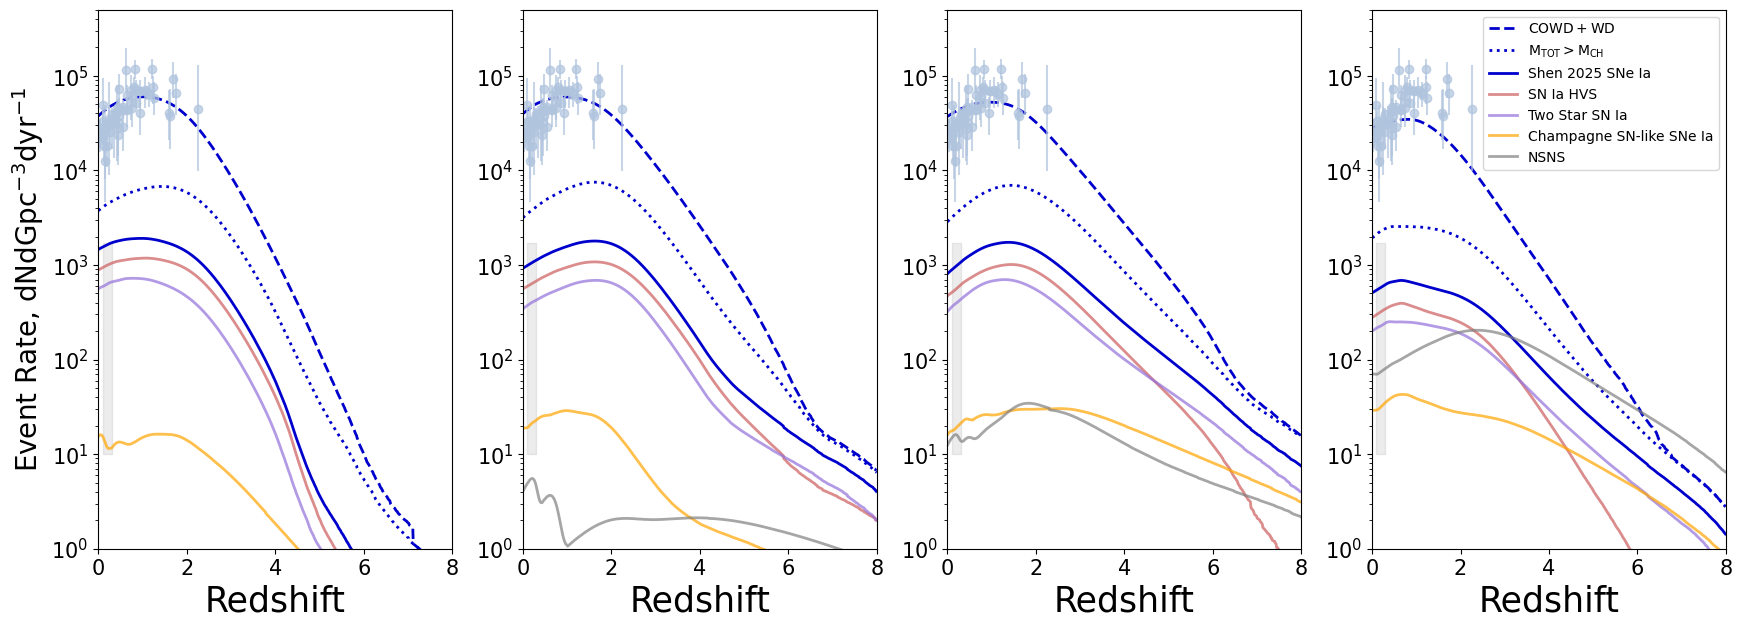

In [ ]:

###### Redshift Rates Plots 

fig, ((ax1, ax2, ax3, ax4)) = plt.subplots(1, 4, figsize=(21,7))

### CE 025
# disitninuish things merging before CE or after CE or due to GW
ax1.plot(redshift_rates_data_list[0][7][()],redshift_rates_data_list[0][0],linewidth=2,linestyle='--',color='mediumblue',label=r'$\mathrm{COWD + WD}$') # all COWD

#let's plot the mtot>mchan rate
ax1.plot(redshift_rates_data_list[0][7][()],redshift_rates_data_list[0][1],linewidth=2,linestyle=':',color='mediumblue',label=r'$\mathrm{M_{TOT}>M_{CH}}$') # all COWD

# different types of SN Ia
ax1.plot(redshift_rates_data_list[0][7][()],redshift_rates_data_list[0][2],linewidth=2,color='mediumblue',label='Shen 2025 SNe Ia')

ax1.plot(redshift_rates_data_list[0][7][()],redshift_rates_data_list[0][3],linewidth=2,color='indianred',alpha=0.7,label='SN Ia HVS')
ax1.plot(redshift_rates_data_list[0][7][()],redshift_rates_data_list[0][4],linewidth=2,color='mediumpurple',alpha=0.7,label='Two Star SN Ia')
ax1.plot(redshift_rates_data_list[0][7][()],redshift_rates_data_list[0][5],linewidth=2,color='orange',alpha=0.7,label='Champagne SN-like SNe Ia')

# NSNS Rate
ax1.plot(redshift_rates_data_list[0][7][()],redshift_rates_data_list[0][6],linewidth=2,color='grey',alpha=0.7,label='NSNS')

## LVK BNS rate
ax1.fill_between([0.1,0.3], 
                10,
                1700, 
                alpha=0.15, 
                color="grey")#,label=r'LVK BNS Rate $\mathrm{z=0.2}$')


## seeing if this plot matches Max Briel's paper
ax1.errorbar(redshifts_briel,converted_rates_briel,yerr=y_error, fmt='o', color = 'lightsteelblue', alpha=0.7)#,label='Briel et al. 2020')


## axis
ax1.set_xlim(0,8)
ax1.set_ylim(10**0,5*10**5)
ax1.set_yscale('log')
ax1.set_ylabel(r"Event Rate, $\mathrm{dNdGpc^{-3}dyr^{-1}}$",fontsize=20)
ax1.set_xlabel(r"Redshift",fontsize=25)
ax1.tick_params(labelsize=15)
# ax1.title(r"Binary White Dwarf (WD+WD) Merger Rate Distirbution")
# ax1.legend()





### CE 05

# disitninuish things merging before CE or after CE or due to GW
ax2.plot(redshift_rates_data_list[1][7][()],redshift_rates_data_list[1][0],linewidth=2,linestyle='--',color='mediumblue',label=r'$\mathrm{COWD + WD}$') # all COWD

#let's plot the mtot>mchan rate
ax2.plot(redshift_rates_data_list[1][7][()],redshift_rates_data_list[1][1],linewidth=2,linestyle=':',color='mediumblue',label=r'$\mathrm{M_{TOT}>M_{CH}}$') # all COWD

# different types of SN Ia
ax2.plot(redshift_rates_data_list[1][7][()],redshift_rates_data_list[1][2],linewidth=2,color='mediumblue',label='Shen 2025 SNe Ia')

ax2.plot(redshift_rates_data_list[1][7][()],redshift_rates_data_list[1][3],linewidth=2,color='indianred',alpha=0.7,label='SN Ia HVS')
ax2.plot(redshift_rates_data_list[1][7][()],redshift_rates_data_list[1][4],linewidth=2,color='mediumpurple',alpha=0.7,label='Two Star SN Ia')
ax2.plot(redshift_rates_data_list[1][7][()],redshift_rates_data_list[1][5],linewidth=2,color='orange',alpha=0.7,label='Champagne SN-like SNe Ia')

# NSNS Rate
ax2.plot(redshift_rates_data_list[1][7][()],redshift_rates_data_list[1][6],linewidth=2,color='grey',alpha=0.7,label='NSNS')

## LVK BNS rate
ax2.fill_between([0.1,0.3], 
                10,
                1700, 
                alpha=0.15, 
                color="grey")#,label=r'LVK BNS Rate $\mathrm{z=0.2}$')


## seeing if this plot matches Max Briel's paper
ax2.errorbar(redshifts_briel,converted_rates_briel,yerr=y_error, fmt='o', color = 'lightsteelblue', alpha=0.7)#,label='Briel et al. 2020')


## axis
ax2.set_xlim(0,8)
ax2.set_ylim(10**0,5*10**5)
ax2.set_yscale('log')
# ax2.set_ylabel(r"Event Rate, $\mathrm{dNdGpc^{-3}dyr^{-1}}$",fontsize=20)
ax2.set_xlabel(r"Redshift",fontsize=25)
ax2.tick_params(labelsize=15)
# ax1.title(r"Binary White Dwarf (WD+WD) Merger Rate Distirbution")
# ax1.legend()





## CE075
### CE 05

# disitninuish things merging before CE or after CE or due to GW
ax3.plot(redshift_rates_data_list[2][7][()],redshift_rates_data_list[2][0],linewidth=2,linestyle='--',color='mediumblue',label=r'$\mathrm{COWD + WD}$') # all COWD

#let's plot the mtot>mchan rate
ax3.plot(redshift_rates_data_list[2][7][()],redshift_rates_data_list[2][1],linewidth=2,linestyle=':',color='mediumblue',label=r'$\mathrm{M_{TOT}>M_{CH}}$') # all COWD

# different types of SN Ia
ax3.plot(redshift_rates_data_list[2][7][()],redshift_rates_data_list[2][2],linewidth=2,color='mediumblue',label='Shen 2025 SNe Ia')

ax3.plot(redshift_rates_data_list[2][7][()],redshift_rates_data_list[2][3],linewidth=2,color='indianred',alpha=0.7,label='SN Ia HVS')
ax3.plot(redshift_rates_data_list[2][7][()],redshift_rates_data_list[2][4],linewidth=2,color='mediumpurple',alpha=0.7,label='Two Star SN Ia')
ax3.plot(redshift_rates_data_list[2][7][()],redshift_rates_data_list[2][5],linewidth=2,color='orange',alpha=0.7,label='Champagne SN-like SNe Ia')

# NSNS Rate
ax3.plot(redshift_rates_data_list[2][7][()],redshift_rates_data_list[2][6],linewidth=2,color='grey',alpha=0.7,label='NSNS')

## LVK BNS rate
ax3.fill_between([0.1,0.3], 
                10,
                1700, 
                alpha=0.15, 
                color="grey")#,label=r'LVK BNS Rate $\mathrm{z=0.2}$')


## seeing if this plot matches Max Briel's paper
ax3.errorbar(redshifts_briel,converted_rates_briel,yerr=y_error, fmt='o', color = 'lightsteelblue', alpha=0.7)#,label='Briel et al. 2020')


## axis
ax3.set_xlim(0,8)
ax3.set_ylim(10**0,5*10**5)
ax3.set_yscale('log')
# ax3.set_ylabel(r"Event Rate, $\mathrm{dNdGpc^{-3}dyr^{-1}}$",fontsize=20)
ax3.set_xlabel(r"Redshift",fontsize=25)
ax3.tick_params(labelsize=15)





### CE2
### CE 05

# disitninuish things merging before CE or after CE or due to GW
ax4.plot(redshift_rates_data_list[3][7][()],redshift_rates_data_list[3][0],linewidth=2,linestyle='--',color='mediumblue',label=r'$\mathrm{COWD + WD}$') # all COWD

#let's plot the mtot>mchan rate
ax4.plot(redshift_rates_data_list[3][7][()],redshift_rates_data_list[3][1],linewidth=2,linestyle=':',color='mediumblue',label=r'$\mathrm{M_{TOT}>M_{CH}}$') # all COWD

# different types of SN Ia
ax4.plot(redshift_rates_data_list[3][7][()],redshift_rates_data_list[3][2],linewidth=2,color='mediumblue',label='Shen 2025 SNe Ia')

ax4.plot(redshift_rates_data_list[3][7][()],redshift_rates_data_list[3][3],linewidth=2,color='indianred',alpha=0.7,label='SN Ia HVS')
ax4.plot(redshift_rates_data_list[3][7][()],redshift_rates_data_list[3][4],linewidth=2,color='mediumpurple',alpha=0.7,label='Two Star SN Ia')
ax4.plot(redshift_rates_data_list[3][7][()],redshift_rates_data_list[3][5],linewidth=2,color='orange',alpha=0.7,label='Champagne SN-like SNe Ia')

# NSNS Rate
ax4.plot(redshift_rates_data_list[3][7][()],redshift_rates_data_list[3][6],linewidth=2,color='grey',alpha=0.7,label='NSNS')

## LVK BNS rate
ax4.fill_between([0.1,0.3], 
                10,
                1700, 
                alpha=0.15, 
                color="grey")#,label=r'LVK BNS Rate $\mathrm{z=0.2}$')


## seeing if this plot matches Max Briel's paper
ax4.errorbar(redshifts_briel,converted_rates_briel,yerr=y_error, fmt='o', color = 'lightsteelblue', alpha=0.7)#,label='Briel et al. 2020')


## axis
ax4.set_xlim(0,8)
ax4.set_ylim(10**0,5*10**5)
ax4.set_yscale('log')
# ax4.set_ylabel(r"Event Rate, $\mathrm{dNdGpc^{-3}dyr^{-1}}$",fontsize=20)
ax4.set_xlabel(r"Redshift",fontsize=25)
ax4.tick_params(labelsize=15)
# ax1.title(r"Binary White Dwarf (WD+WD) Merger Rate Distirbution")
ax4.legend()


# save figure
# plt.savefig("./figures/redshift_rates_plots/redshift_rates_plots_all.png",bbox_inches='tight',pad_inches=0.2)